In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

In [2]:
import jax
import jax.numpy as jnp

from jax import random
main_rng = random.PRNGKey(421)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
import flax
from flax import linen as nn

In [4]:
from utils_display import nice_colorbar
from jax_transformer_display_helpers import display_scaled_dot_product

from jax_transformer import MultiheadAttention
from jax_transformer import EncoderBlock
from jax_transformer import TransformerEncoder
from jax_transformer import scaled_dot_product
from jax_transformer import expand_mask

# Scaled dot product attention

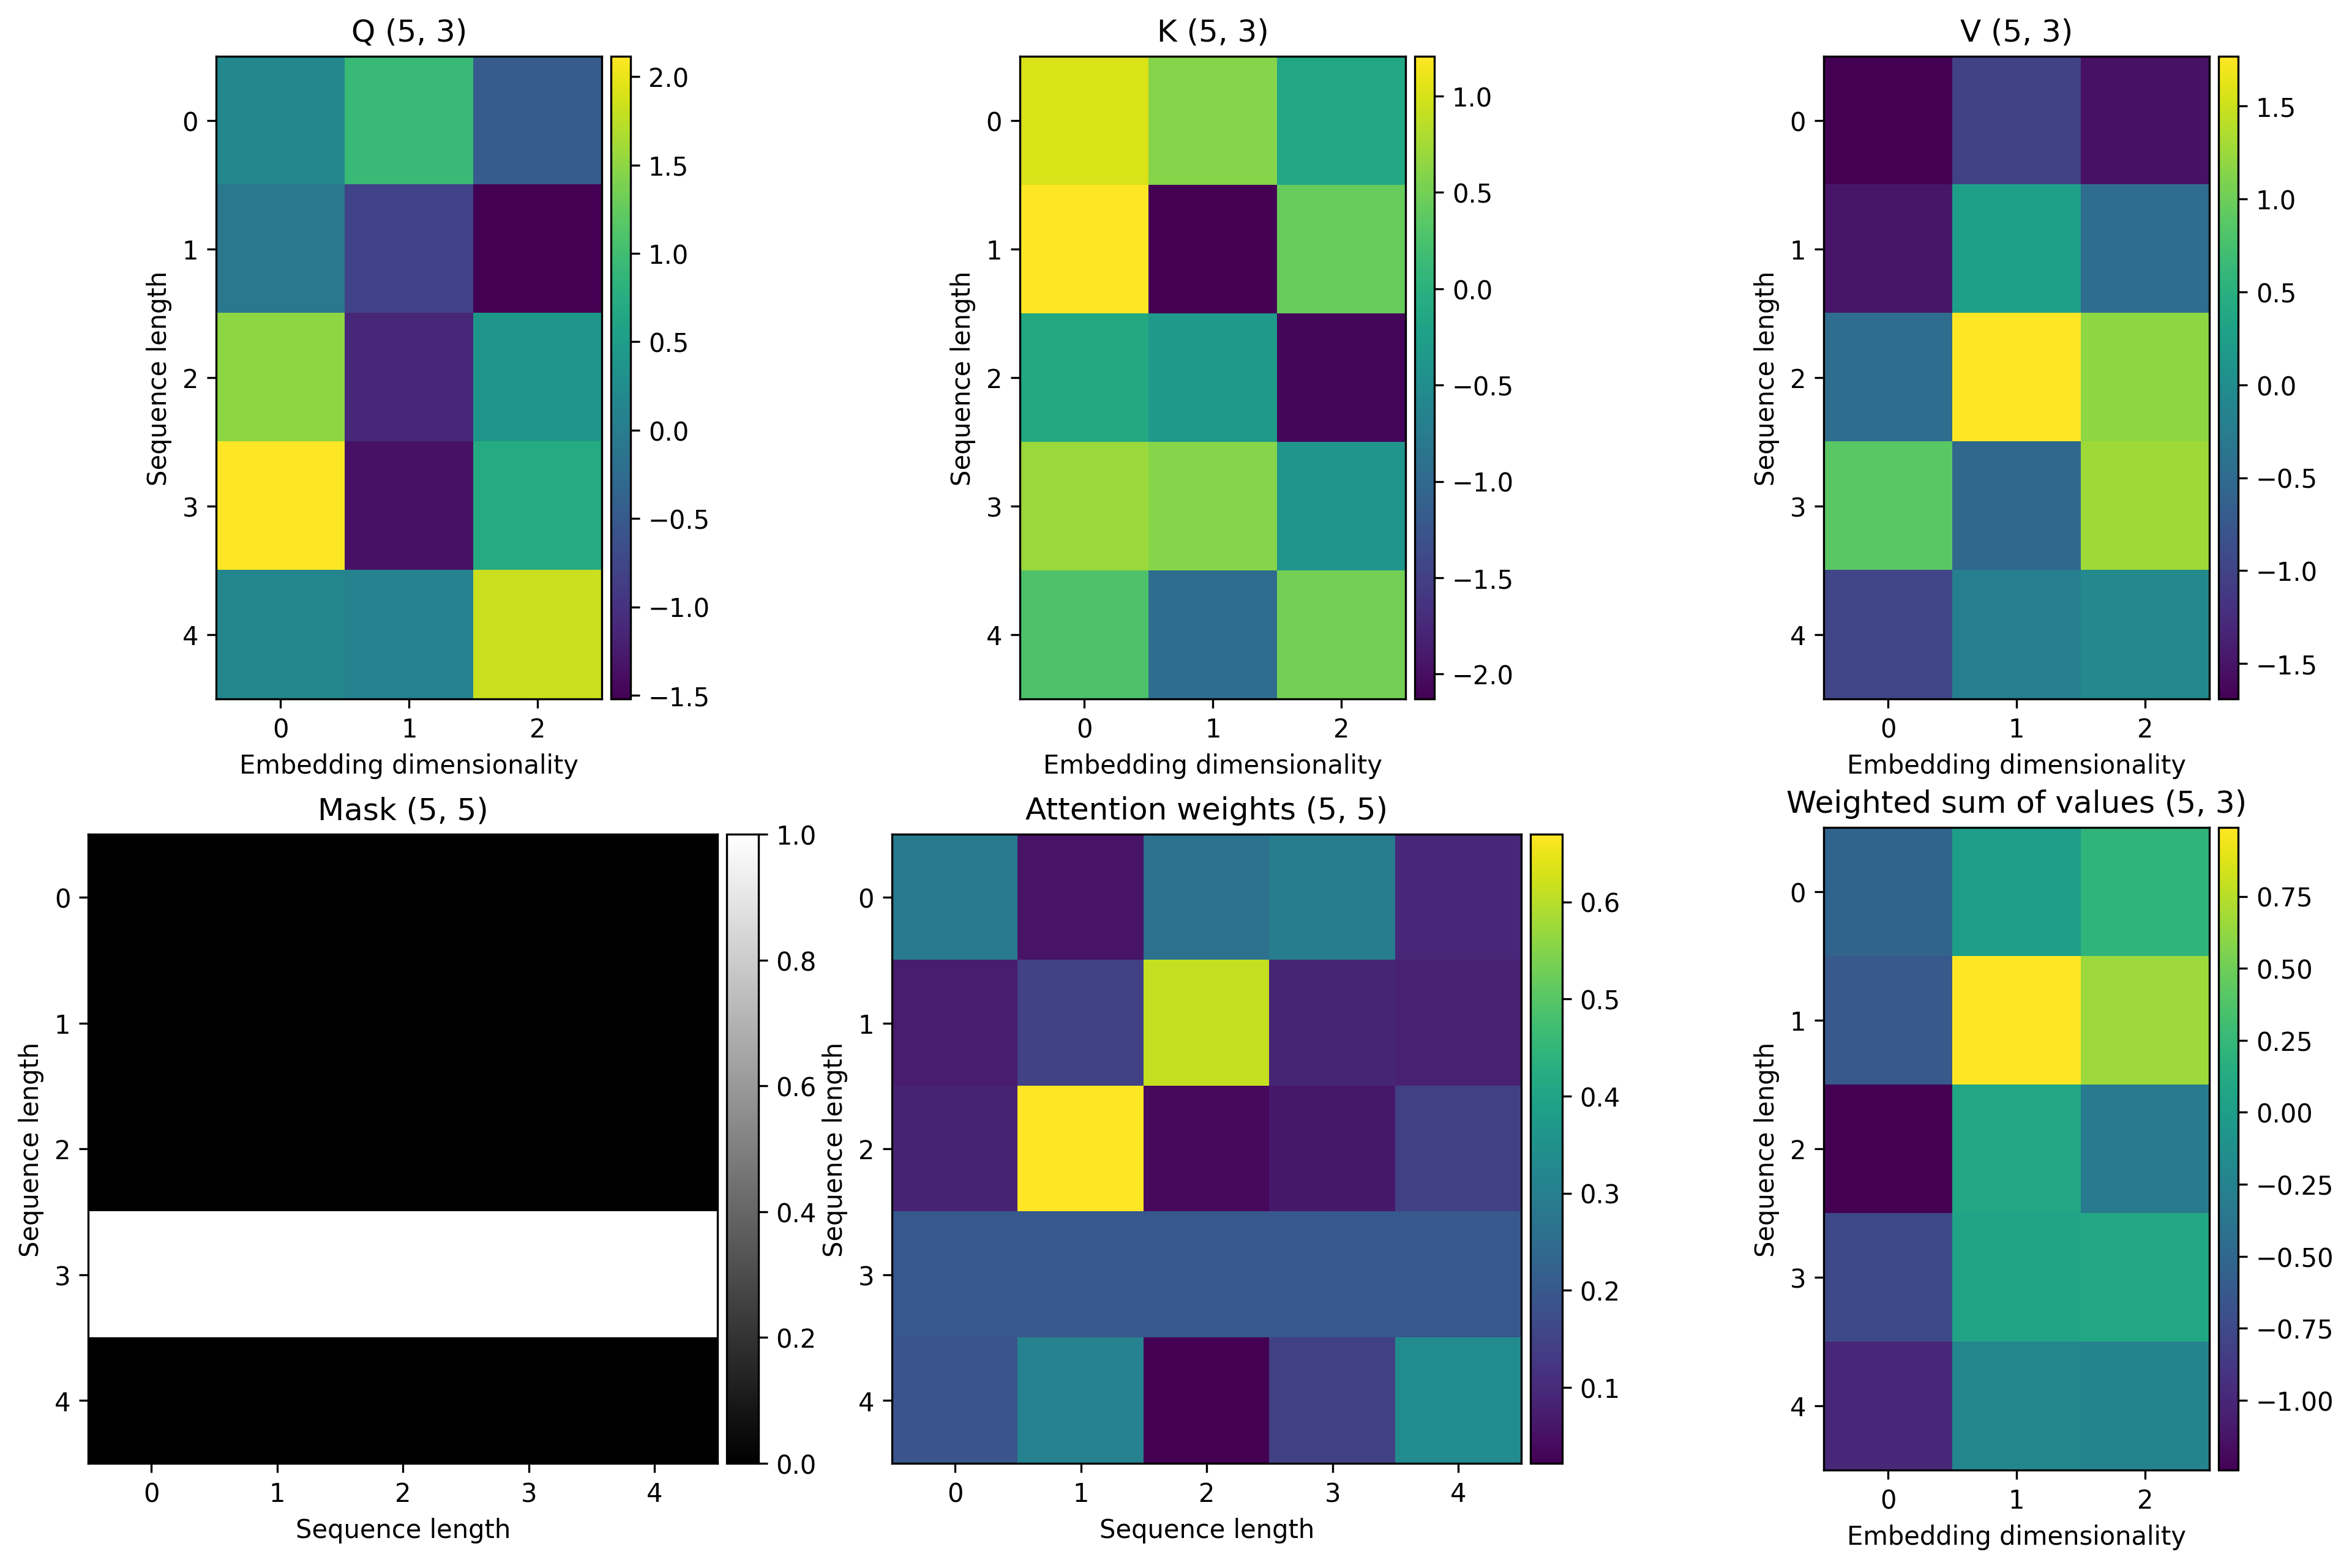

In [5]:
sequence_length = 5
embedding_dimensionality = 3

_, rand1 = random.split(main_rng)

qkv = random.normal(rand1, (3, sequence_length, embedding_dimensionality))
q, k, v = qkv[0], qkv[1], qkv[2]

mask = jnp.zeros((sequence_length, sequence_length))
mask = mask.at[3,:].set(1)

weighted_sum_of_values, attention_weights = scaled_dot_product(q, k, v, mask)
                 
display_scaled_dot_product(q, k, v, mask, weighted_sum_of_values, attention_weights)

# Multi-head attention

In [6]:
## Test MultiheadAttention implementation

batch_size = 2
sequence_length = 13
embedding_dimensionality = 32
number_of_heads = 4

main_rng, x_rng = random.split(main_rng)

x = random.normal(x_rng, (batch_size, sequence_length, embedding_dimensionality))

mha = MultiheadAttention(embedding_dimensionality=embedding_dimensionality, number_of_heads=number_of_heads)

main_rng, init_rng = random.split(main_rng)

params = mha.init(init_rng, x)['params']
w_o, attention_weights = mha.apply({'params': params}, x)

print('Out', w_o.shape, 'Attention', attention_weights.shape)

del w_o, attention_weights

Out (2, 13, 32) Attention (2, 4, 13, 13)


# Transformer encoder

In [7]:
## Test EncoderBlock implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create encoder block
encblock = EncoderBlock(input_dimensionality=128, number_of_heads=4, feedforward_dimensionality=512, dropout_probability=0.1)
# Initialize parameters of encoder block with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = encblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = encblock.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del encblock, params

Out (3, 16, 128)


In [8]:
## Test TransformerEncoder implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create Transformer encoder
transenc = TransformerEncoder(
    number_of_layers=5,
    input_dimensionality=128,
    number_of_heads=4,
    feedforward_dimensionality=256,
    dropout_probability=0.15)

# Initialize parameters of transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transenc.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply transformer with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transenc.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transenc, binded_mod, params

Out (3, 16, 128)
Attention maps 5 (3, 4, 16, 16)


# Positional encoding

In [9]:
class PositionalEncoding(nn.Module):

    hidden_dimensionality : int
    maximum_sequence_length : int = 5000

    def setup(self):
        positional_encoding = np.zeros((self.maximum_sequence_length, self.hidden_dimensionality))
        position = np.arange(0, self.maximum_sequence_length, dtype=np.float32)[:,None]
        denominator = np.exp(np.arange(0, self.hidden_dimensionality, 2) * (-math.log(10000.0) / self.hidden_dimensionality))
        positional_encoding[:, 0::2] = np.sin(position * denominator)
        positional_encoding[:, 1::2] = np.cos(position * denominator)
        positional_encoding = positional_encoding[None]
        self.positional_encoding = jax.device_put(positional_encoding)

    def __call__(self, x):
        x = x + self.positional_encoding[:, :x.shape[1]]
        return x

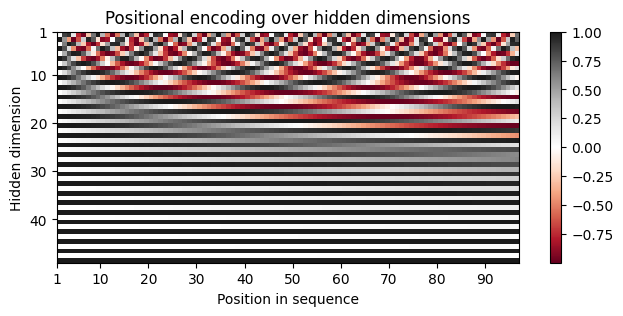

In [10]:
# Create encoding block, bind to access positional encoding (module has no parameters)
encod_block = PositionalEncoding(hidden_dimensionality=48, maximum_sequence_length=96).bind({})
# Obtain positional encodings as numpy array
positional_encoding = jax.device_get(encod_block.positional_encoding.squeeze().T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(positional_encoding, cmap="RdGy", extent=(1,positional_encoding.shape[1]+1,positional_encoding.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+positional_encoding.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+positional_encoding.shape[0]//10)])
plt.show()

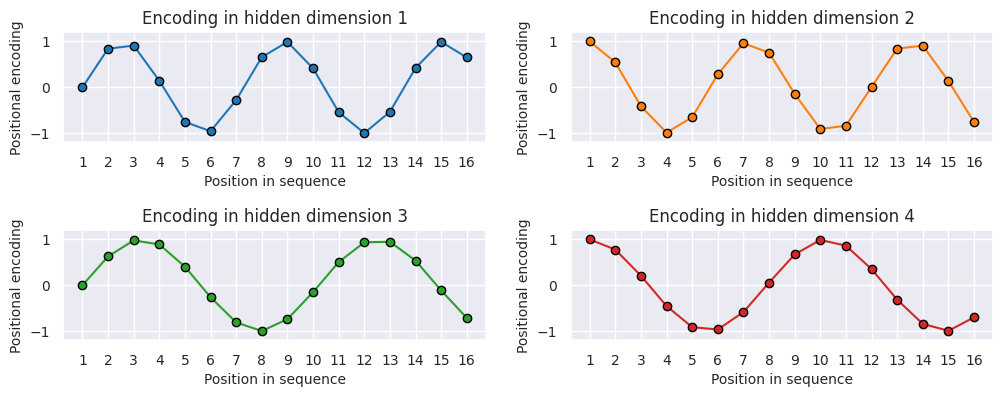

In [11]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), positional_encoding[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

In [12]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [13]:
def cosine_warmup_schedule(base_lr: float, warmup: int, max_iters: int):
    assert warmup > 0 and max_iters > 0
    # Create function to return lr based on iteration count
    def get_lr(train_iter):
        lr_factor = 0.5 * (1 + np.cos(np.pi * train_iter / max_iters))
        if train_iter <= warmup:
            lr_factor *= train_iter * 1.0 / warmup
        return lr_factor * base_lr
    return get_lr



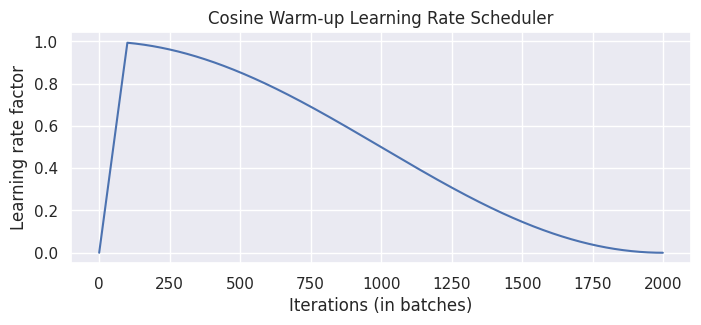

In [14]:
lr_scheduler = cosine_warmup_schedule(base_lr=1.0, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()



# Full transformer model

In [15]:
class TransformerPredictor(nn.Module):
    model_dim : int                   # Hidden dimensionality to use inside the Transformer
    num_classes : int                 # Number of classes to predict per sequence element
    num_heads : int                   # Number of heads to use in the Multi-Head Attention blocks
    num_layers : int                  # Number of encoder blocks to use
    dropout_prob : float = 0.0        # Dropout to apply inside the model
    input_dropout_prob : float = 0.0  # Dropout to apply on the input features

    def setup(self):
        
        self.input_dropout = nn.Dropout(self.input_dropout_prob)
        self.input_layer = nn.Dense(self.model_dim)        
        self.positional_encoding = PositionalEncoding(self.model_dim)
        feedforward_dimensionality = 4 * self.model_dim
        
        self.transformer = TransformerEncoder(
            number_of_layers=self.num_layers,
            input_dimensionality=self.model_dim,
            number_of_heads=self.num_heads,
            feedforward_dimensionality=feedforward_dimensionality,
            dropout_probability=self.dropout_prob)

        # Output classifier to convert each token vector into a probability distribution over the token vocabulary
        # To perforem next token prediction
        self.output_net = [
            nn.Dense(self.model_dim),
            nn.LayerNorm(),
            nn.relu,
            nn.Dropout(self.dropout_prob),
            nn.Dense(self.num_classes)]

    def __call__(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
            train - If True, dropout is stochastic
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask, train=train)


        for l in self.output_net:
            x = l(x) if not isinstance(l, nn.Dropout) else l(x, deterministic=not train)

        return x

    def get_attention_maps(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask, train=train)
        return attention_maps

In [16]:
main_rng, x_rng = random.split(main_rng)

x = random.normal(x_rng, (3, 16, 1))

transpre = TransformerPredictor(num_layers=5,
                                model_dim=128,
                                num_classes=10,
                                num_heads=4,
                                dropout_prob=0.15,
                                input_dropout_prob=0.05)

# Initialize parameters of transformer predictor with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transpre.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']

print('[initialization finished]')

# Apply transformer predictor with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)

# Instead of passing params and rngs every time to a function call, we can bind them to the module
model = transpre.bind({'params': params}, rngs={'dropout': dropout_apply_rng})


out = model(x, mask=None, add_positional_encoding=True, train=True)
print('Out', out.shape)


attn_maps = model.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transpre, model, params

[initialization finished]
Out (3, 16, 10)
Attention maps 5 (3, 4, 16, 16)


# Trainer

In [17]:
class TrainerModule:

    def __init__(self, model_name, exmp_batch, max_iters, lr=1e-3, warmup=100, seed=42, **model_kwargs):
        """
        Inputs:
            model_name - Name of the model. Used for saving and checkpointing
            exmp_batch - Example batch to the model for initialization
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            seed - Seed to use for model init
        """
        super().__init__()
        self.model_name = model_name
        self.max_iters = max_iters
        self.lr = lr
        self.warmup = warmup
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = TransformerPredictor(**model_kwargs)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_batch)

    def batch_to_input(self, exmp_batch):
        # Map batch to input data to the model
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def get_loss_function(self):
        # Return a function that calculates the loss for a batch
        # To be implemented in a task specific sub-class
        raise NotImplementedError

    def create_functions(self):
        # Create jitted train and eval functions
        calculate_loss = self.get_loss_function()

        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, rng = ret[0], *ret[1]
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        self.train_step = jax.jit(train_step)

        # Evaluation function
        def eval_step(state, rng, batch):
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return acc, rng
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_batch):
        # Initialize model
        self.rng = jax.random.PRNGKey(self.seed)
        self.rng, init_rng, dropout_init_rng = jax.random.split(self.rng, 3)
        exmp_input = self.batch_to_input(exmp_batch)
        params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng}, exmp_input, train=True)['params']
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=self.warmup,
            decay_steps=self.max_iters,
            end_value=0.0
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=500):
        # Train model for defined number of epochs
        best_acc = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 5 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/accuracy', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_acc:
                    best_acc = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        accs, losses = [], []
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, self.rng, loss, accuracy = self.train_step(self.state, self.rng, batch)
            losses.append(loss)
            accs.append(accuracy)
        avg_loss = np.stack(jax.device_get(losses)).mean()
        avg_acc = np.stack(jax.device_get(accs)).mean()
        self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
        self.logger.add_scalar('train/accuracy', avg_acc, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all data points of a data loader and return avg accuracy
        correct_class, count = 0, 0
        for batch in data_loader:
            acc, self.rng = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, step=step)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for the pretrained model
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params)
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=self.state.params)
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this Transformer
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

In [ ]:
class mlm_dataset(data.Dataset):

    def __init__(self, num_categories, maximum_sequence_length, size, np_rng):
        super().__init__()
        self.num_categories = num_categories
        self.maximum_sequence_length = maximum_sequence_length
        self.size = size
        self.np_rng = np_rng

        self.data = self.np_rng.integers(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        inputs = self.data[index]
        labels = xxx
        return inputs, labels